In [1]:
%pip install -q numpy matplotlib scipy
%pip install -q "signal-temporal-logic[parser] @ git+https://github.com/ERATOMMSD/signal-temporal-logic@v0.2.1"


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

from signal_tl import Signal, Predicate, compute_robustness
from signal_tl.plot import plot_robustness

plt.rcParams['figure.figsize'] = [10, 4]

## Glossary

- *Time horizon*: positive real value $T$
- *Signal*: a function $\sigma: \mathbb{R} \mapsto [0, T]$
- *Sampling points*: an ascending series $t_1 \le \dots \le t_N$, where $t_1=0$ and $t_N < T$
- *Control points*: a (small) subset of sampling points $t_{c_1}, \le t_{c_M}$, whose size is $M$
- *Sample sequence*: a sequence $(t_1, v_1), \dots. (t_N, v_N)$, where $\{t_i\}_i$ are sampling points and $v_i \in \mathbb{R}$ 

REMARK: We assume a sample sequence represents a piecewise linear signal.

In [3]:
# Hyperparameters

time_step = 0.1
time_horizon = 10
n_cp = 5 

In [4]:
# utils

def pick_n_dividing_points(target: np.ndarray, n: int, force_include_end = False) -> np.ndarray:
    if force_include_end:
        q = len(target) / (n - 1)
        idx = [*[int(np.floor(i * q)) for i in range(n-1)], -1]
    else:
        q = len(target) / n
        idx = [int(np.floor(i * q)) for i in range(n)]
    return target[idx]

def plot_signal(signal):
    plt.plot(signal.times, signal.values, '.-')

def plot_trace(trace, title=None, sharey=True, show_markers=False, **figure_args):
    fig, ax = plt.subplots(len(trace), sharex=True, sharey=sharey, **figure_args)
    for i, (name, signal) in enumerate(trace.items()):
        if show_markers:
            ax[i].plot(signal.times, signal.values, '.-')
        else:
            ax[i].plot(signal.times, signal.values, '-')
        ax[i].set_title(name)
    if title:
        fig.suptitle(title, color='red')

Generate sampling points periodically.

And we pick control points following the rules below (the is not necessary but I guess a good practice).

- Each control points are picked from sampling points
- `cp[0] = 0`
- `cp[-1] = sampling_points[-1]`
- Control points devide $[0, T]$ as evenly as possible 

In [5]:
sampling_points = np.arange(0, time_horizon, time_step)
control_points = pick_n_dividing_points(sampling_points, n_cp, force_include_end=True)


An $M$-dimensional value $(v_1,\dots, v_M) \in \mathbb{R}^M$ specifies $\sigma(t_{c_1}) = v_1, \dots, \sigma(t_{c_M}) = v_M$.
For the values at the other points, assuming piecewise-constant or piecewise-linear is standard way in literature.

We here adopt another approach, because in such formalisms, there is no stable way to define its *derivatives*, which commonly appears in our STL formulas like `x < 2 /\ x' > 0`.

Especially,
- Higher-order derivatives are nonsense in such formalisms
- [Finite difference](https://en.wikipedia.org/wiki/Finite_difference) method poorly approximates the derivatives, since the time delta $t_{c_{i+1}} - t_{c_i}$ is not so small.



Thus, we try to fit a cubic [spline curve function](https://en.wikipedia.org/wiki/B-spline) $B(t)$ on    the control points.
$B(t)$ is a continuous piecewise-polynomial function with the properties:
- $B(t_{c_i}) = v_i$
- $B(t), B'(t), B''(t)$ are continuous
- $B'''(t)$ is not continuous (I guess this is not significant)

After that we can consistently define $\sigma(t), \dots, \sigma'''(t)$ (straightforward from $B(t), \dots, B'''(t)$).

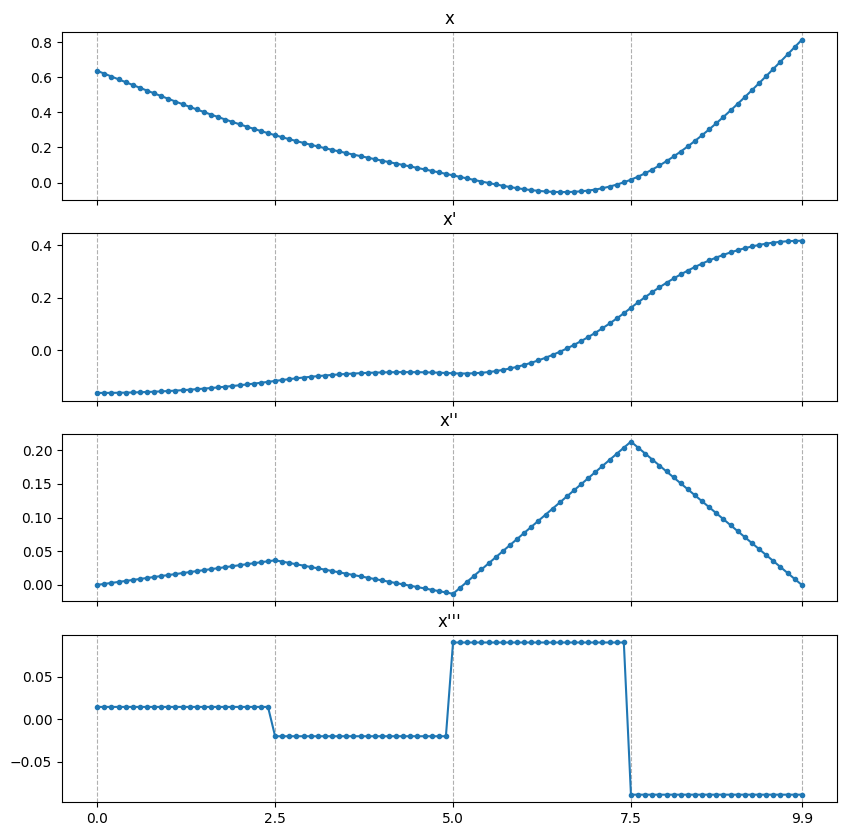

In [6]:
# Signal generation

def generate_diff_signals(
    symbol: str,
    control_points,
    valuation,
    times,
    max_deriv_order=0
):
    if max_deriv_order < 0:
        raise ValueError("max_deriv_order=#{max_deriv_order} given."
                         "Derivative order shoud be a non-negative integer.")
    elif max_deriv_order > 3:
        raise ValueError("max_deriv_order=#{max_deriv_order} given."
                         "Currently only n<=3 order of derivatives are supported.")

    spline = CubicSpline(
        control_points,
        valuation,
        bc_type="natural",  # boundary condition. f''(0) == f''(T) == 0.
    )
    def nth_deriv(n):
        return Signal(spline(times, n), times)
    return {
        (symbol + "'" * i): nth_deriv(i) 
        for i in range(max_deriv_order + 1)
    }

sample_trace = generate_diff_signals("x", control_points, np.random.default_rng(0).random(n_cp), sampling_points, max_deriv_order=3)

plot_trace(sample_trace, sharey=False, show_markers=True, figsize=[10,10])

for ax in plt.gcf().axes:  # Grid on control points
    ax.set_xticks(control_points)
    ax.grid(axis="x", linestyle="--")

In [7]:
def generate_trace(control_points, sampled_point, times):
    valuation_x = sampled_point[:len(control_points)]
    valuation_y = sampled_point[len(control_points):]
    xs = generate_diff_signals("x", control_points, valuation_x, times, max_deriv_order=3)
    ys = generate_diff_signals("y", control_points, valuation_y, times, max_deriv_order=3)
    return {
        **xs,
        **ys,
    }

In [8]:
# Spec definition
from signal_tl.parser import SpecLoader

spec = SpecLoader()

spec.def_predicate(
    "danger", ["x", "y"],
    "y - x <= 10"
).def_predicate(
    "car", ["c"],
    "c' > 5 /\   c' >= 5 /\ c' <= 27 /\ c'' >= 0 - 3 /\ c'' <= 3 /\ c''' >= 0 - 5 /\ c''' <= 5"
).def_predicate(
    "sim", ["x", "y"],
    "x == 0 /\ y == 45 /\ (eventually [0,7] danger(x,y)) /\ (always car(x) /\ car(y) /\ x <= y)"
).def_predicate(
    "ass", ["x", "y"],
    "True"
).def_function(
    "dist", ["x", "y"],
    "y - x"
)

# Formulas can be equivalently written in DSL style, e.g.:
# from signal_tl.ast import *
# And(Eq(lhs="x", rhs=0), Eq(lhs="y", rhs="45", Eventually(PredicateCall(symbol="danger", inputs=["x", "y"]), interval=(0, 7)), ...)

spec.eval_robustness("sim(x, y)", generate_trace(control_points, np.arange(n_cp*2), sampling_points))


-39.999

Optimization part.

In [9]:
from cmaes import CMA
import time

search_dim = len(control_points) * 2  # Two signals are generated

optimizer = CMA(
    mean=np.zeros(search_dim),  # Initial mean
    sigma=1.3,  # Initial standard deviation. sigma=1.3 is OK for most purposes.
    bounds=None,  # Lower and upper boundaries can be specified
    seed=0,
    )

history = []
falsified_traces = []
generation = 0

t1 = time.time()

# Exemplification is minimization of "[[signal, ~sim]]"
while not optimizer.should_stop() and len(falsified_traces) < 5:  # Continue our search until 5 feasibles are found
    solutions = []
    for _ in range(optimizer.population_size):  # Batch-evaluation
        x = optimizer.ask()
        trace = generate_trace(control_points, x, sampling_points)
        value = spec.eval_robustness("~sim(x, y)", trace)
        history.append((x, trace, value))
        if value < 0:
            falsified_traces.append(trace)
            print(f"#{generation} {value} (x1={x[0]}, x2 = {x[1]})")
        solutions.append((x, value))
    optimizer.tell(solutions)

    generation += 1

elapsed = time.time() - t1

#170 -0.0001457864139760524 (x1=0.0008542135860239476, x2 = 15.760350410416713)
#183 -0.0005631977717257541 (x1=-2.4717548228757747e-05, x2 = 16.06804014343191)
#184 -0.0003185810015224888 (x1=-0.00012644034669126382, x2 = 16.149782862167747)
#186 -0.0004912534057502791 (x1=-0.000508746594249721, x2 = 16.166230449111197)
#187 -0.00038170030683805703 (x1=-0.000618299693161943, x2 = 16.058032020760518)


In [10]:
elapsed

5.860139846801758

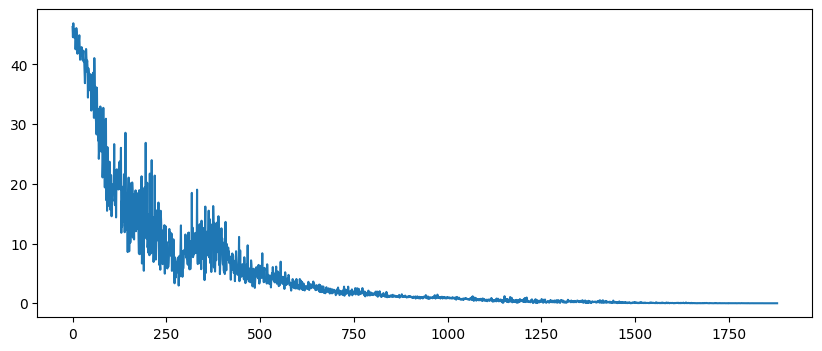

In [11]:
# Optimization history

plt.plot([robustness for (_, _, robustness) in history])

Inspect the best signal found.

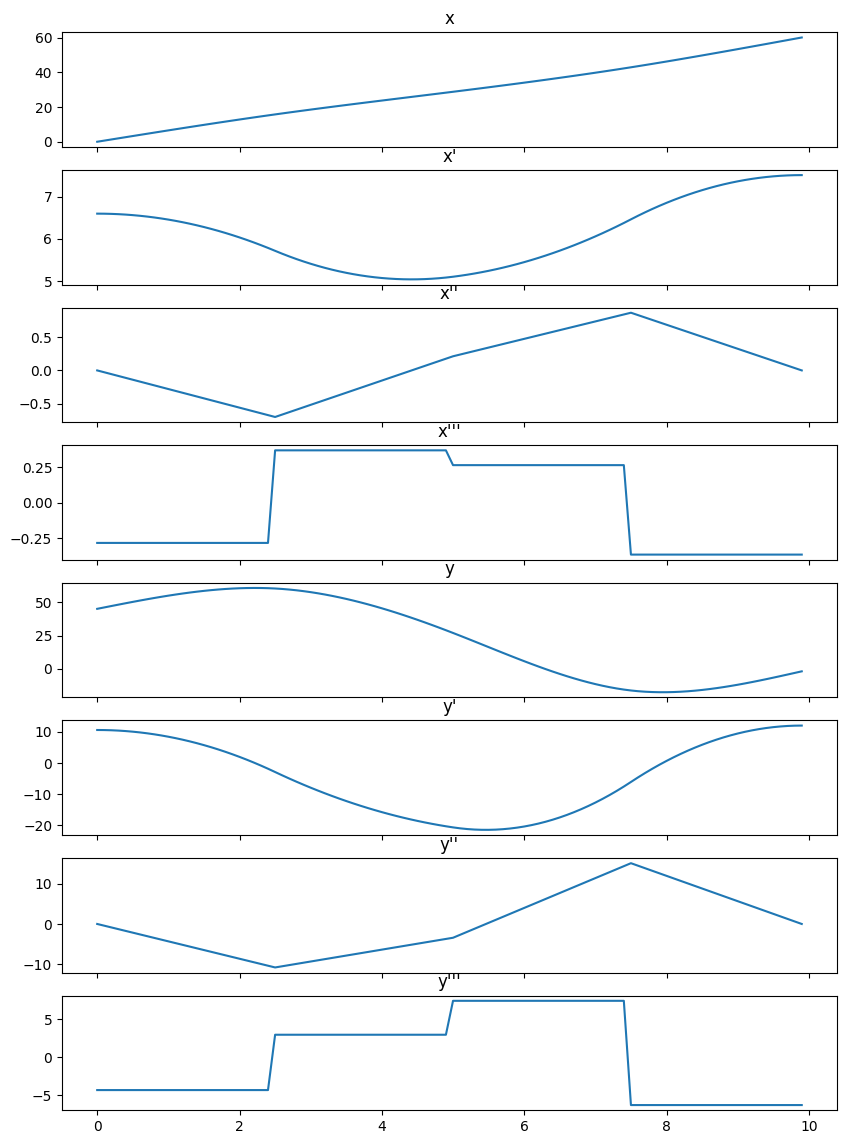

In [12]:
# Show the best signal

results = falsified_traces if len(falsified_traces) != 0 else history[:-5]

plot_trace(results[0], sharey=False, figsize=[10, 14])


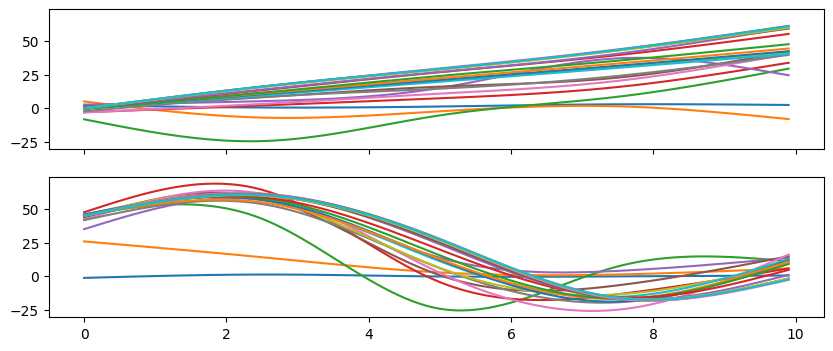

In [ ]:
# Show some (5%) of all generated signals

def plot_traces_xy(traces, **figure_args):
    fig, ax = plt.subplots(2, sharex=True, sharey=True, **figure_args)
    for trace in traces:
        ax[0].plot(trace["x"].times, trace["x"].values)
        ax[1].plot(trace["y"].times, trace["y"].values)
traces = [trace for (_, trace, _) in history]
plot_traces_xy(traces[::len(traces)//20])